In [1]:
import numpy as np
import pandas as pd

from gensim import corpora
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from nltk.stem import SnowballStemmer

from keras.preprocessing import sequence
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Embedding
from keras.layers import LSTM
from sklearn import preprocessing
from sklearn.metrics import (precision_score, recall_score,
                             f1_score, accuracy_score,mean_squared_error,mean_absolute_error)
np.random.seed(0)
from tensorflow.keras.optimizers import RMSprop
from keras import callbacks
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger

### word2vec

In [2]:
from __future__ import print_function
from collections import OrderedDict

import time
import _pickle as cPickle

import urllib
import matplotlib.pyplot as plt

import os
import sys
import codecs
import re
import numpy as np

parameters = OrderedDict()
parameters['word_dim'] = 300

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
def importtxtfile(path):
  df = open(path, 'r')
  df = [line.strip().split('\t') for line in df.readlines()]
  df = pd.DataFrame(df, columns = ['id' , 'tweet', 'tweettype', 'score'])
  df = df.drop([0], axis=0)
  return df

In [5]:
angerdatatrain = importtxtfile('/content/drive/MyDrive/wassa/training/anger-ratings-0to1.train.txt')
feardatatrain = importtxtfile('/content/drive/MyDrive/wassa/training/fear-ratings-0to1.train.txt')
joydatatrain = importtxtfile('/content/drive/MyDrive/wassa/training/joy-ratings-0to1.train.txt')
sadnessdatatrain = importtxtfile('/content/drive/MyDrive/wassa/training/sadness-ratings-0to1.train.txt')
traindata = pd.concat([angerdatatrain, feardatatrain, joydatatrain, sadnessdatatrain])
traindata

,id,tweet,tweettype,score
1,10000,How the fu*k! Who the heck! moved my fridge!.....,anger,0.938
2,10001,So my Indian Uber driver just called someone t...,anger,0.896
3,10002,@DPD_UK I asked for my parcel to be delivered ...,anger,0.896
4,10003,so ef whichever butt wipe pulled the fire alar...,anger,0.896
5,10004,Don't join @BTCare they put the phone down on ...,anger,0.896
...,...,...,...,...
782,40781,@VivienLloyd Thank you so much! Just home - st...,sadness,0.104
783,40782,Just put the winter duvet on ☃️❄️🌬☔️,sadness,0.104
784,40783,@SilkInSide @TommyJoeRatliff that's so pretty!...,sadness,0.088
785,40784,@BluesfestByron second artist announcement loo...,sadness,0.083


In [6]:
angerdatatest = importtxtfile('/content/drive/MyDrive/wassa/testing/anger-ratings-0to1.test.target.txt')
feardatatest = importtxtfile('/content/drive/MyDrive/wassa/testing/fear-ratings-0to1.test.target.txt')
joydatatest = importtxtfile('/content/drive/MyDrive/wassa/testing/joy-ratings-0to1.test.target.txt')
sadnessdatatest = importtxtfile('/content/drive/MyDrive/wassa/testing/sadness-ratings-0to1.test.target.txt')
testdata = pd.concat([angerdatatest, feardatatest, joydatatest, sadnessdatatest])
testdata

,id,tweet,tweettype,score
1,10941,At the point today where if someone says somet...,anger,NONE
2,10942,@CorningFootball IT'S GAME DAY!!!! T MIN...,anger,NONE
3,10943,This game has pissed me off more than any othe...,anger,NONE
4,10944,@spamvicious I've just found out it's Candice ...,anger,NONE
5,10945,@moocowward @mrsajhargreaves @Melly77 @GaryBar...,anger,NONE
...,...,...,...,...
669,41528,Why does Candice constantly pout #GBBO 💄😒,sadness,NONE
670,41529,"@redBus_in #unhappy with #redbus CC, when I ta...",sadness,NONE
671,41530,"@AceOperative789 no pull him afew weeks ago, s...",sadness,NONE
672,41531,I'm buying art supplies and I'm debating how s...,sadness,NONE


In [7]:
angerdatatest = importtxtfile('/content/drive/MyDrive/wassa/validation/anger-ratings-0to1.dev.gold.txt')
feardatatest = importtxtfile('/content/drive/MyDrive/wassa/validation/fear-ratings-0to1.dev.gold.txt')
joydatatest = importtxtfile('/content/drive/MyDrive/wassa/validation/joy-ratings-0to1.dev.gold.txt')
sadnessdatatest = importtxtfile('/content/drive/MyDrive/wassa/validation/sadness-ratings-0to1.dev.gold.txt')
valdata = pd.concat([angerdatatest, feardatatest, joydatatest, sadnessdatatest])
valdata

,id,tweet,tweettype,score
1,10857,@ZubairSabirPTI pls dont insult the word 'Molna',anger,0.479
2,10858,@ArcticFantasy I would have almost took offens...,anger,0.458
3,10859,@IllinoisLoyalty that Rutgers game was an abom...,anger,0.562
4,10860,@CozanGaming that's what lisa asked before she...,anger,0.500
5,10861,Sometimes I get mad over something so minuscul...,anger,0.708
...,...,...,...,...
70,40855,Common app just randomly logged me out as I wa...,sadness,0.833
71,40856,"I'd rather laugh with the rarest genius, in be...",sadness,0.688
72,40857,If you #invest in my new #film I will stop ask...,sadness,0.458
73,40858,"Just watched Django Unchained, Other people ma...",sadness,0.333


In [8]:
datanew = pd.concat([traindata, valdata])
datanew = datanew.reset_index()
datanew
# datanew[datanew['score'].to_string() == 'NONE']

,index,id,tweet,tweettype,score
0,1,10000,How the fu*k! Who the heck! moved my fridge!.....,anger,0.938
1,2,10001,So my Indian Uber driver just called someone t...,anger,0.896
2,3,10002,@DPD_UK I asked for my parcel to be delivered ...,anger,0.896
3,4,10003,so ef whichever butt wipe pulled the fire alar...,anger,0.896
4,5,10004,Don't join @BTCare they put the phone down on ...,anger,0.896
...,...,...,...,...,...
3955,70,40855,Common app just randomly logged me out as I wa...,sadness,0.833
3956,71,40856,"I'd rather laugh with the rarest genius, in be...",sadness,0.688
3957,72,40857,If you #invest in my new #film I will stop ask...,sadness,0.458
3958,73,40858,"Just watched Django Unchained, Other people ma...",sadness,0.333


In [9]:
pd.to_numeric(datanew['score'])

0       0.938
1       0.896
2       0.896
3       0.896
4       0.896
        ...  
3955    0.833
3956    0.688
3957    0.458
3958    0.333
3959    0.708
Name: score, Length: 3960, dtype: float64

In [10]:
datanew = datanew.drop(datanew[pd.to_numeric(datanew['score']) < 0.7].index) #, inplace = True
datanew

,index,id,tweet,tweettype,score
0,1,10000,How the fu*k! Who the heck! moved my fridge!.....,anger,0.938
1,2,10001,So my Indian Uber driver just called someone t...,anger,0.896
2,3,10002,@DPD_UK I asked for my parcel to be delivered ...,anger,0.896
3,4,10003,so ef whichever butt wipe pulled the fire alar...,anger,0.896
4,5,10004,Don't join @BTCare they put the phone down on ...,anger,0.896
...,...,...,...,...,...
3921,36,40821,It feel like we lost a family member🙄😂,sadness,0.708
3922,37,40822,My life went from happy to unhappy..,sadness,0.812
3946,61,40846,Should of stayed in Dubai 😞,sadness,0.708
3955,70,40855,Common app just randomly logged me out as I wa...,sadness,0.833


In [11]:
## encode sentiment column to onehot
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown='ignore')
enc.fit(datanew['tweettype'].to_numpy().reshape(-1, 1))
onehot_sentiment = enc.transform(datanew['tweettype'].to_numpy().reshape(-1, 1)).toarray()
# onehot_sentiment = onehot_sentiment.reshape((40000, 1, 13))
datanew.insert(1, "onehot_sentiment", list(onehot_sentiment))
datanew

,index,onehot_sentiment,id,tweet,tweettype,score
0,1,"[1.0, 0.0, 0.0, 0.0]",10000,How the fu*k! Who the heck! moved my fridge!.....,anger,0.938
1,2,"[1.0, 0.0, 0.0, 0.0]",10001,So my Indian Uber driver just called someone t...,anger,0.896
2,3,"[1.0, 0.0, 0.0, 0.0]",10002,@DPD_UK I asked for my parcel to be delivered ...,anger,0.896
3,4,"[1.0, 0.0, 0.0, 0.0]",10003,so ef whichever butt wipe pulled the fire alar...,anger,0.896
4,5,"[1.0, 0.0, 0.0, 0.0]",10004,Don't join @BTCare they put the phone down on ...,anger,0.896
...,...,...,...,...,...,...
3921,36,"[0.0, 0.0, 0.0, 1.0]",40821,It feel like we lost a family member🙄😂,sadness,0.708
3922,37,"[0.0, 0.0, 0.0, 1.0]",40822,My life went from happy to unhappy..,sadness,0.812
3946,61,"[0.0, 0.0, 0.0, 1.0]",40846,Should of stayed in Dubai 😞,sadness,0.708
3955,70,"[0.0, 0.0, 0.0, 1.0]",40855,Common app just randomly logged me out as I wa...,sadness,0.833


### encode word

In [12]:
def create_dico(item_list):
    """
    Create a dictionary of items from a list of list of items.
    (item:count) pairs
    """
    assert type(item_list) is list
    dico = {}
    for items in item_list:
        for item in items:
            if item not in dico:
                dico[item] = 1
            else:
                dico[item] += 1
    return dico

def create_mapping(dico):
    """
    Create a mapping (item to ID / ID to item) from a dictionary.
    Items are ordered by decreasing frequency.
    """
    sorted_items = sorted(dico.items(), key=lambda x: (-x[1], x[0]))
    id_to_item = {i: v[0] for i, v in enumerate(sorted_items)}
    item_to_id = {v: k for k, v in id_to_item.items()}
    return item_to_id, id_to_item

def word_mapping(sentences, lower):
    """
    Create a dictionary and a mapping of words, sorted by frequency.
    
    return:
    dico: dictionary of (word:frequency) pairs
    word_to_id: dictionary of (word, id)
    id_to_word: dictionary of (id, word)
    """
    words = [[x.lower() if lower else x[0] for x in s] for s in sentences]
    dico = create_dico(words)
    dico['<UNK>'] = 10000000 #UNK tag for unknown words
    word_to_id, id_to_word = create_mapping(dico)
    print("Found %i unique words (%i in total)" % (
        len(dico), sum(len(x) for x in words)
    ))
    return dico, word_to_id, id_to_word

In [13]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [14]:
## tokenising sentences
raw_content = datanew['tweet'].to_numpy()

processed_docs = []
for doc in raw_content:
    tokens = word_tokenize(doc)
#        filtered = [word for word in tokens if word not in stop_words]
#        stemmed = [stemmer.stem(word) for word in filtered]
    processed_docs.append(tokens)

In [15]:
dico_words,word_to_id,id_to_word = word_mapping(processed_docs, True)

Found 2790 unique words (12393 in total)


In [16]:
def lower_case(x,lower=False):
    if lower:
        return x.lower()  
    else:
        return x

In [17]:
def prepare_dataset(sentences, word_to_id, lower=False):
    """
    Prepare the dataset. Return a list of lists of dictionaries containing:
        - word indexes
        - word char indexes
        - tag indexes
    """
    data = []
    for s in sentences:
        str_words = [w for w in s]
        words = [word_to_id[lower_case(w,lower) if lower_case(w,lower) in word_to_id else '<UNK>']
                 for w in str_words]
        data.append({
            'str_words': str_words, #list of all words in the sentence
            'words': words, #list of word index for all words in the sentence
        })
    return data

data = prepare_dataset(
    processed_docs, word_to_id, True
)

print("{} sentences".format(len(data)))

625 sentences


In [18]:
all_word_embeds = {}
for i, line in enumerate(codecs.open('/content/drive/MyDrive/data/glove.6B.300d.txt', 'r', 'utf-8')):
    s = line.strip().split()
    if len(s) == parameters['word_dim'] + 1:
        all_word_embeds[s[0]] = np.array([float(i) for i in s[1:]])

#Intializing Word Embedding Matrix
word_embeds = np.random.uniform(-np.sqrt(0.06), np.sqrt(0.06), (len(word_to_id), parameters['word_dim']))

for w in word_to_id:
    if w in all_word_embeds:
        word_embeds[word_to_id[w]] = all_word_embeds[w]
    elif w.lower() in all_word_embeds:
        word_embeds[word_to_id[w]] = all_word_embeds[w.lower()]

print('Loaded %i pretrained embeddings.' % len(all_word_embeds))

Loaded 400000 pretrained embeddings.


In [19]:
word_indices = [i['words'] for i in data]
padded_indices = []
for sent in word_indices:
    padding_size = 110 - len(sent)
    padded = sent + [0 for i in range(padding_size)]
    padded_indices.append(padded)

In [20]:
datanew.insert(1, "padded_indices", list(padded_indices))
datanew

,index,padded_indices,onehot_sentiment,id,tweet,tweettype,score
0,1,"[75, 5, 762, 6, 108, 5, 792, 6, 516, 12, 760, ...","[1.0, 0.0, 0.0, 0.0]",10000,How the fu*k! Who the heck! moved my fridge!.....,anger,0.938
1,2,"[18, 12, 383, 1017, 718, 28, 677, 172, 5, 236,...","[1.0, 0.0, 0.0, 0.0]",10001,So my Indian Uber driver just called someone t...,anger,0.896
2,3,"[4, 1504, 2, 633, 19, 12, 2165, 7, 27, 368, 7,...","[1.0, 0.0, 0.0, 0.0]",10002,@DPD_UK I asked for my parcel to be delivered ...,anger,0.896
3,4,"[18, 722, 1029, 674, 1035, 913, 5, 482, 620, 1...","[1.0, 0.0, 0.0, 0.0]",10003,so ef whichever butt wipe pulled the fire alar...,anger,0.896
4,5,"[30, 21, 1864, 4, 1309, 132, 335, 5, 284, 135,...","[1.0, 0.0, 0.0, 0.0]",10004,Don't join @BTCare they put the phone down on ...,anger,0.896
...,...,...,...,...,...,...,...
3921,36,"[16, 64, 45, 56, 118, 8, 180, 2017, 0, 0, 0, 0...","[0.0, 0.0, 0.0, 1.0]",40821,It feel like we lost a family member🙄😂,sadness,0.708
3922,37,"[12, 87, 2656, 51, 37, 7, 2596, 0, 0, 0, 0, 0,...","[0.0, 0.0, 0.0, 1.0]",40822,My life went from happy to unhappy..,sadness,0.812
3946,61,"[130, 13, 2459, 15, 1513, 1060, 0, 0, 0, 0, 0,...","[0.0, 0.0, 0.0, 1.0]",40846,Should of stayed in Dubai 😞,sadness,0.708
3955,70,"[1373, 630, 28, 2271, 1953, 17, 49, 74, 2, 32,...","[0.0, 0.0, 0.0, 1.0]",40855,Common app just randomly logged me out as I wa...,sadness,0.833


In [21]:
from sklearn.model_selection import train_test_split
X = datanew['padded_indices'].to_numpy()
y = datanew['onehot_sentiment'].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("X train: ", len(X_train), X_train.shape)
print("y train: ", len(y_train), y_train.shape)
print("y test: ", len(y_test), y_test.shape)

X train:  500 (500,)
y train:  500 (500,)
y test:  125 (125,)


In [22]:
X_train = np.array([np.array(x) for x in X_train])
y_train = np.array([np.array(x) for x in y_train])
X_test = np.array([np.array(x) for x in X_test])
y_test = np.array([np.array(x) for x in y_test])

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(500, 110)
(500, 4)
(125, 110)
(125, 4)


### Zhou model

In [23]:
# so that dont have to rerun
import tensorflow as tf
tf.compat.v1.reset_default_graph()

In [24]:
!pip install keras_self_attention

  Created wheel for keras-self-attention: filename=keras_self_attention-0.50.0-py3-none-any.whl size=19414 sha256=c8efd3ce5c48d4add88762a428df0e1a686d10b05e7294218d8c146f75cd7bb5
  Stored in directory: /root/.cache/pip/wheels/92/7a/a3/231bef5803298e7ec1815215bc0613239cb1e9c03c57b13c14
Successfully built keras-self-attention


In [25]:
import tensorflow as tf
from tensorflow.keras import layers
import keras
from keras_self_attention import SeqSelfAttention, SeqWeightedAttention


class ZhouBLSTMCNNModel:

    def __init__(self,
        embedding,
        em_drop_rate = 0.5,
        lstm_units   = 300,
        lstm_drop_rate = 0.5,
        conv_size    = (3, 3),
        conv_filters = 100,
        pool_size    = (2, 2),
        pool_drop_rate = 0.5):
        '''Constructor.
        # Parameters:
        embedding: Numpy array representing the embedding.
        em_drop_rate: Drop rate after the embedding layer.
        lstm_units: Size of the internal states of the LSTM cells.
        lstm_drop_rate: Drop rate after the lstm layer.
        conv_size: Size of the convolutions.
        conv_filters: Number of convolutions filters.
        pool_size: Size for the max pooling layer.
        pool_drop_rate: Drop rate of the max pooling layer.
        '''
        self._embedding      = embedding
        self._em_drop_rate   = em_drop_rate
        self._lstm_units     = lstm_units
        self._lstm_drop_rate = lstm_drop_rate
        self._conv_size      = conv_size
        self._conv_filters   = conv_filters
        self._pool_size      = pool_size
        self._pool_drop_rate = pool_drop_rate

    def __call__(self, input):
        self._embedding_tf = self._create_embedding_layer(
            self._em_drop_rate, self._embedding, input)

        self._sequences_tf = self._create_blstm_layer(
            self._lstm_units,
            self._lstm_drop_rate,
            self._embedding_tf)

        self._convolution_tf = self._create_convolutional_layer(
            self._conv_size,
            self._conv_filters,
            self._sequences_tf)
        
        self._pooling_tf = self._create_maxpooling_layer(
            self._pool_size,
            self._pool_drop_rate,
            self._convolution_tf)

        self._flatten_tf = self._create_flatten_layer(self._pooling_tf)

        return self._flatten_tf

    def summary(self):
        print("embedding: " + str(self._embedding_tf.shape))
        print("lstm: " + str(self._sequences_tf.shape))
        print("conv: " + str(self._convolution_tf.shape))
        print("pooling: " + str(self._pooling_tf.shape))
        print("flatten: " + str(self._flatten_tf.shape))

    # this function converts each word from input_x into dense vector of dimension 300 (dimension depending on word2vec)
    # embedding  = word_vector
    def _create_embedding_layer(self, em_drop_rate, embedding, input_x):
        embedding = tf.Variable(initial_value=embedding)

        embedded_chars = tf.nn.embedding_lookup(  # lookup word_vector(embedding) by index (input_x)
            embedding, tf.cast(input_x, 'int32'))

        return tf.nn.dropout(embedded_chars, rate=em_drop_rate)

    # bidirectional lstm layer
    # 
    def _create_blstm_layer(self, lstm_units, lstm_drop_rate, embedding):
        lstm_cell = tf.compat.v1.nn.rnn_cell.BasicRNNCell(lstm_units)
        sequence = tf.unstack(embedding, axis=1) #embedded input words
        
        # hs, _, _ are outputs, output_state_fw, output_state_bw respectively
        hs, _, _ = tf.compat.v1.nn.static_bidirectional_rnn(lstm_cell, lstm_cell, #forward and backward direction
            sequence, #input
            dtype=tf.float32)
        
        hs = tf.stack(
            values=hs,
            axis=1)
        ss = tf.math.reduce_sum(
            tf.reshape(hs, shape=[-1, hs.shape[1], 2, lstm_units]),
            axis=2
        )
        
        # attn = SeqSelfAttention(attention_activation='sigmoid',attention_type=SeqSelfAttention.ATTENTION_TYPE_MUL)(ss)

        return tf.nn.dropout(ss, rate=lstm_drop_rate)

    def _create_convolutional_layer(self,
        conv_size, num_filters, tensor):
        
        print(str(tensor.shape))

        filter_heigth = conv_size[0]
        filter_width  = conv_size[1]

        filter_shape = [filter_heigth, filter_width,
            1, num_filters]

        W = tf.Variable(
            initial_value=tf.random.truncated_normal(
                shape=filter_shape,
                stddev=0.1))
        b = tf.Variable(
            initial_value=tf.random.truncated_normal(
                shape=[num_filters]))

        tensor_expanded = tf.expand_dims(tensor, -1)
        conv = tf.nn.conv2d(
            input=tensor_expanded,
            filters=W, #####filter to filters, idk if it changed stuff
            strides=[1,1,1,1],
            padding='VALID')

        bias = tf.nn.bias_add(conv, b)
        c = tf.nn.relu(bias)

        return c

    def _create_maxpooling_layer(self, size, pool_drop_rate, conv):
        pooled = tf.nn.max_pool3d(
            input=tf.expand_dims(conv, -1),
            ksize=[1, size[0], size[1], conv.shape[3], 1],
            strides=[1, size[0], size[1], conv.shape[3], 1],
            padding='VALID')
        
        return tf.nn.dropout(pooled, rate=pool_drop_rate)

    def _create_flatten_layer(self, tensor):
        return tf.reshape(tensor, [-1, tensor.shape[1] * tensor.shape[2]])


if __name__ == '__main__':
    embedding_size  = 300
    num_words       = 1000
    sentence_length = 10

    embedding = [
        [float(i) for i in range(embedding_size)] for _ in range(num_words)
    ]
    data = [
        [i     for i in range(sentence_length)],
        [i + 1 for i in range(sentence_length)]
    ]

    model = ZhouBLSTMCNNModel(embedding)
    model(data)
    model.summary()

Instructions for updating:
Please use `keras.layers.Bidirectional(keras.layers.RNN(cell, unroll=True))`, which is equivalent to this API
Instructions for updating:
Please use `keras.layers.RNN(cell, unroll=True)`, which is equivalent to this API


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:81: UserWarning: `tf.nn.rnn_cell.BasicRNNCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.SimpleRNNCell`, and will be replaced by that in Tensorflow 2.0.
/usr/local/lib/python3.7/dist-packages/keras/layers/legacy_rnn/rnn_cell_impl.py:459: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  shape=[input_depth + self._num_units, self._num_units])
/usr/local/lib/python3.7/dist-packages/keras/layers/legacy_rnn/rnn_cell_impl.py:463: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  initializer=tf.compat.v1.zeros_initializer(dtype=self.dtype))


(2, 10, 300)
embedding: (2, 10, 300)
lstm: (2, 10, 300)
conv: (2, 8, 298, 100)
pooling: (2, 4, 149, 1, 1)
flatten: (2, 596)


In [26]:
import tensorflow as tf
from numba import jit, cuda

class Classifier:

    def __init__(self, model, input_length, output_length):
        '''Constructor.
        # Parameters:
        input_length: sentence length (max number of words in sentence)
        output_length: number of classes of sentiment
        '''
        self.model = model
        self.input_length = input_length
        self.output_length = output_length

    def compile(self, batch_size=32):
        tf.compat.v1.disable_eager_execution()
        self._ds_x = tf.compat.v1.placeholder(tf.float32, [None, self.input_length])
        self._ds_y = tf.compat.v1.placeholder(tf.float32, [None, self.output_length])

        ds = tf.compat.v1.data.Dataset.from_tensor_slices((self._ds_x, self._ds_y))
        ds = ds.batch(batch_size)

        self._ds_it = ds.make_initializable_iterator()
        self._input, self._labels = self._ds_it.get_next()

        self._features = self.model(self._input)
        self._output = _create_dense_layer(self._features, self.output_length)

        self._create_acc_computations()
        self._create_backpropagation()

        self._session = tf.compat.v1.Session()
        self._session.run(tf.compat.v1.global_variables_initializer())
        self._session.run(tf.compat.v1.local_variables_initializer())

    def _create_acc_computations(self):
        self._predictions = tf.argmax(self._output, 1)
        labels = tf.argmax(self._labels, 1)
        self._accuracy = tf.reduce_mean(
            tf.cast(tf.equal(self._predictions, labels), 'float32'))

    def _create_backpropagation(self):
        losses = tf.compat.v1.nn.softmax_cross_entropy_with_logits_v2(
            logits=self._output,
            labels=self._labels)
        self._loss = tf.reduce_mean(losses)

        optimizer = tf.compat.v1.train.AdamOptimizer(0.001)
        global_step = tf.Variable(0, name="global_step", trainable=False)
        grads_and_vars = optimizer.compute_gradients(self._loss)

        self._train_op = optimizer.apply_gradients(
            grads_and_vars, global_step=global_step)

    def summary(self):
        print('input:', self._input.shape)
        self.model.summary()
        print('output:', self._output.shape)

#     @jit(target ="cuda")  
    def train(self, X_train, y_train, X_eval, y_eval, epochs=10):
        import time
        start_train = time.time()
        losslist = []
        acclist = []
        val_losslist = []
        val_acclist =[]
        for e in range(epochs):
            start_time = time.time()
            loss, acc = self._train(X_train, y_train)
            losslist.append(loss)
            acclist.append(acc)
            duration = time.time() - start_time

            val_loss, val_acc = self._eval(X_eval, y_eval)
            val_losslist.append(val_loss)
            val_acclist.append(val_acc)
            
            output = 'Epoch: {}, loss = {:.4f}, acc = {:.4f}, val_loss = {:.4f}, val_acc = {:.4f}, Time = {:.2f}s'
            print(output.format(e + 1, loss, acc, val_loss, val_acc, duration))
        
        total_duration = time.time() - start_train
        return losslist, acclist, val_losslist, val_acclist, total_duration

#     @jit(target ="cuda")  
    def _train(self, X_train, y_train):
        import numpy as np

        self._session.run(
            fetches=self._ds_it.initializer,
            feed_dict={
                self._ds_x: X_train,
                self._ds_y: y_train
            })
        loss, acc, = [], []
        while True:
            try:
                _, vloss, vacc = self._session.run(
                    fetches=[self._train_op, self._loss, self._accuracy])

                loss.append(vloss)
                acc.append(vacc)
            except tf.errors.OutOfRangeError:
                break
        # endwhile

        loss, acc = np.mean(loss), np.mean(acc)
        return loss, acc

    def _eval(self, X_val, y_val):
        self._session.run(
            fetches=self._ds_it.initializer,
            feed_dict={
                self._ds_x: X_val,
                self._ds_y: y_val
            })

        loss, acc, = 0, 0
        while True:
            try:
                l, vloss, vacc = self._session.run(
                    fetches=[self._labels, self._loss, self._accuracy])

                loss += vloss * len(l)
                acc += vacc * len(l)
            except tf.errors.OutOfRangeError:
                break

        return loss / len(X_val), acc / len(X_val)

    def predict(self, X):
        import numpy as np

        self._session.run(self._ds_it.initializer,
                         feed_dict={
                             self._ds_x: X,
                             self._ds_y: np.empty((len(X), self.output_length))
                         }
                         )

        pred = list()
        while True:
            try:
                ppred = self._session.run(tf.nn.softmax(self._output))

                pred.extend(map(lambda l: l.tolist(), ppred))
            except tf.errors.OutOfRangeError:
                break

        return pred

def _create_dense_layer(x, output_length):
    '''Creates a dense layer
    '''
    input_size = x.shape[1] #.value
    W = tf.Variable(
        initial_value=tf.random.truncated_normal(
            shape=[input_size, output_length],
            stddev=0.1))
    b = tf.Variable(
        initial_value=tf.random.truncated_normal(
            shape=[output_length]))

    dense = tf.compat.v1.nn.xw_plus_b(x, W, b)

    return dense


if __name__ == '__main__':
    pass

In [27]:
import pickle
import numpy as np
import sys
# from fen.classifier import Classifier
# from fen.pzhou_tf import ZhouBLSTMCNNModel

if __name__ == '__main__':

#     (X_train, y_train), (X_eval, y_eval) = (X_train, y_train), (X_test, y_test)

    word_vector = word_embeds
    word_vector = word_vector.astype('float32')
    
    sentence_length = X_train[0].shape[0] # sentence length = 37 -- if less than 37, remaining is 0
    num_classes = y_train[0].shape[0] # 6 sentiment classes

#     with tf.device('/device:GPU:0'):
    model = ZhouBLSTMCNNModel(embedding=word_vector) #pass in word_vector as lookup table

    classifier = Classifier(
        model=model,
        input_length=sentence_length,
        output_length=num_classes)

    classifier.compile(batch_size=10)
    classifier.summary()
    loss, acc, val_loss, val_acc, duration = classifier.train(
        X_train=X_train,
        y_train=y_train,
        X_eval=X_test,
        y_eval=y_test,
        epochs=20
    )

    print("total time taken: ", duration)
    print("Predictions:", classifier.predict(X_train[0:2]))
    print("Real:", y_train[0:2])

Instructions for updating:
This is a deprecated API that should only be used in TF 1 graph mode and legacy TF 2 graph mode available through `tf.compat.v1`. In all other situations -- namely, eager mode and inside `tf.function` -- you can consume dataset elements using `for elem in dataset: ...` or by explicitly creating iterator via `iterator = iter(dataset)` and fetching its elements via `values = next(iterator)`. Furthermore, this API is not available in TF 2. During the transition from TF 1 to TF 2 you can use `tf.compat.v1.data.make_initializable_iterator(dataset)` to create a TF 1 graph mode style iterator for a dataset created through TF 2 APIs. Note that this should be a transient state of your code base as there are in general no guarantees about the interoperability of TF 1 and TF 2 code.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:81: UserWarning: `tf.nn.rnn_cell.BasicRNNCell` is deprecated and will be removed in a future version. This class is equivalent as `tf.keras.layers.SimpleRNNCell`, and will be replaced by that in Tensorflow 2.0.
/usr/local/lib/python3.7/dist-packages/keras/layers/legacy_rnn/rnn_cell_impl.py:459: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  shape=[input_depth + self._num_units, self._num_units])
/usr/local/lib/python3.7/dist-packages/keras/layers/legacy_rnn/rnn_cell_impl.py:463: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  initializer=tf.compat.v1.zeros_initializer(dtype=self.dtype))


(None, 110, 300)
input: (None, 110)
embedding: (None, 110, 300)
lstm: (None, 110, 300)
conv: (None, 108, 298, 100)
pooling: (None, 54, 149, 1, 1)
flatten: (None, 8046)
output: (None, 4)
Epoch: 1, loss = 20.4459, acc = 0.2620, val_loss = 21.3285, val_acc = 0.2000, Time = 9.81s
Epoch: 2, loss = 19.2139, acc = 0.2260, val_loss = 18.8646, val_acc = 0.2640, Time = 5.74s
Epoch: 3, loss = 17.0734, acc = 0.2860, val_loss = 18.1852, val_acc = 0.2640, Time = 5.95s
Epoch: 4, loss = 16.5353, acc = 0.2920, val_loss = 18.0137, val_acc = 0.2240, Time = 5.97s
Epoch: 5, loss = 15.2553, acc = 0.2640, val_loss = 19.8588, val_acc = 0.2320, Time = 5.39s
Epoch: 6, loss = 15.4414, acc = 0.2740, val_loss = 17.7233, val_acc = 0.2000, Time = 5.38s
Epoch: 7, loss = 15.6761, acc = 0.2620, val_loss = 13.6254, val_acc = 0.2800, Time = 5.93s
Epoch: 8, loss = 13.4177, acc = 0.2640, val_loss = 13.8062, val_acc = 0.2400, Time = 5.83s
Epoch: 9, loss = 14.1050, acc = 0.2540, val_loss = 13.3412, val_acc = 0.2480, Time = 5

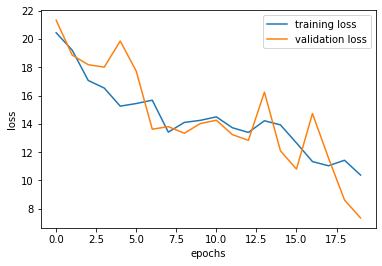

In [35]:
epochslist = [i for i in range(0,20)]
plt.plot(epochslist, loss, label='training loss')
plt.plot(epochslist, val_loss, label='validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

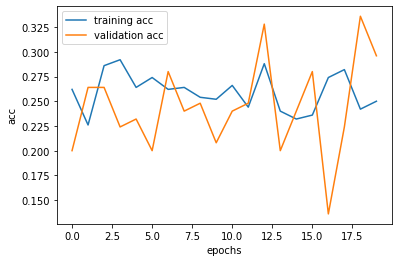

In [33]:
plt.plot(epochslist, acc, label = "training acc")
plt.plot(epochslist, val_acc, label="validation acc")
# plt.title('training acc')
plt.xlabel('epochs')
plt.ylabel('acc')
plt.legend()
plt.show()

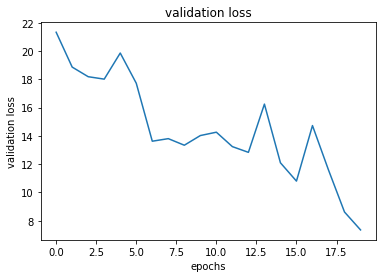

In [30]:
plt.plot(epochslist, val_loss)
plt.title('validation loss')
plt.xlabel('epochs')
plt.ylabel('validation loss')
plt.show()

In [34]:
# plt.plot(epochslist, val_acc)
# plt.title('validation acc')
# plt.xlabel('epochs')
# plt.ylabel('validation acc')
# plt.show()

In [ ]:
device_name = tf.test.gpu_device_name()
print(device_name)

/device:GPU:0


### testing

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1
